# iLQR-VAE tutorial 

In this tutorial, we will do the following : 

* Introduce the iLQR-VAE model
* Illustrate usage of the method on one of the Neural Latents Benchmark datasets (the Maze dataset)
* Illustrate how the flexible inference model can be used on heterogeneous data

The code for the tutorial is in [Ocaml](https://ocaml.org) but no familiarity with the language is necessary to run the tutorial. Much of this tutorial is built on the [iLQR-VAE library](https://github.com/marineschimel/ilqr_vae).

## iLQR-VAE overview


iLQR-VAE is a method for inferring latent dynamics from noisy time series of observations.

It does this by modelling the observations as the output of an *input-driven latent dynamical system*, whose latent trajectories are read out onto the observation space. 

The model is trained by optimizing the parameters to maximize the (marginal) likelihood of the data - essentially, this corresponds to learning the dynamical system that best explains the observations.

As in any VAE, each learning iteration relies on the ability to perform inference for the current set of parameters. In iLQR-VAE, inference is performed using **iLQR**, a powerful optimization algorithm which rapidly converges to the inputs that best explain the data given the parameters. This results in a posterior over latent trajectories which forms the basis of a lower bound on the marginal likelihood -- the training objective.

This differs from other similar methods (e.g LFADS) which instead learn the mapping from observations to latents using neural networks.

The main advantages of iLQR-VAE is that it defines the mapping from data to latents *implicitly*, meaning that it has fewer hyperparameters to tune. This also makes training more robust, and inference more flexible (although not that there is no free lunch, and that the inference step in iLQR-VAE is typically slower than in e.g LFADS). 

### Generative process 

iLQR-VAE models observations (here, spike trains) as the output of an input-driven latent dynamical system (similarly to LFADS)


<img src="figures/generative.png" width="70%"/>



**Details of the generative model**
* $\theta$ are the parameters of the model

* $\mathbf{u}_t \in \mathbb{R}^m$, $\mathbf{z}_t \in \mathbb{R}^n$ and $\mathbf{o}_t \in \mathbb{R}^{n_o}$

* Input-driven latent state dynamics : $\mathbf{z}_{t+1} = f_\theta(\mathbf{z}_t, \mathbf{u}_t, t)$ (note that the dynamics are deterministic given a set of inputs)

* Likelihood given latents : $\mathbf{o}_t | \mathbf{z}_t \sim p_\theta(\mathbf{o}_t | \mathbf{z}_t)$

* Student prior over the inputs (favouring *sparse inputs*) with a special Gaussian prior for the initial input (setting initial condition)





### Inference procedure
To train the model, we optimize $\theta$ to maximize the marginal log-likelihood of observing a collection of independent observation sequences $\mathbf{\mathcal{O}} = \{ \mathbf{o}^{(1)}, \ldots, \mathbf{o}^{(K)} \}$ (trials) given by:
$$
    \log p_\theta(\mathbf{\mathcal{O}})
    =
    \sum_{k=1}^K
    \log \int
    p_\theta(\mathbf{o}^{(k)} |\mathbf{z}(\mathbf{u}))
    p_\theta(\mathbf{u})\,
    d \mathbf{u}
$$

Unfortunately, computing this expression is intractable. A common approach to deal with this problem is to introduce a new distribution $\log q_\phi(\mathbf{u}|\mathbf{o}^{(k)})$, typically chosen to be Gaussian, to approximate the posterior distribution $p_\theta(\mathbf{u}|\mathbf{o}^{(k)})$. This then allows to write down a lower bound on the log-likelihood, called the ELBO :   
$$\mathcal{L}(\mathbf{\mathcal{O}}, \theta, \phi) =
    \sum_k
    \mathbb{E}_{q_\phi(\mathbf{u}|\mathbf{o}^{(k)})}
    \left [
        \sum_{t=1}^T
        \underbrace{\log p_\theta(\mathbf{o}_t^{(k)} | \mathbf{z}_t)}_{\text{reconstruction term}}
        +
         \underbrace{\log p_\theta(\mathbf{u}_t) - 
         \log q_\phi(\mathbf{u}_t|\mathbf{o}^{(k)}}_{\text{regularization term}} )\right]       \\
        \leq \log p_\theta(\mathbf{\mathcal{O}}).$$

We thus also need an expression for $\log q_\phi(\mathbf{u}_t|\mathbf{o}^{(k)})$ : one common approach is to use a Gaussian approximation parameterized with (bi-)RNNs (as in LFADS). This has the disadvantage that it introduces new (hyper)-parameters into the model. Instead, we define $\log q_\phi(\mathbf{u}_t|\mathbf{o}^{(k)})$ to be centered at the *maximum of the true log posterior* $\mathbf{u}^\star$, defined as :
        
 $$\mathbf{u}^\star(\mathbf{o}^{(k)})
      = \underset{\mathbf{u}}{\text{argmax}}\: \log p_\theta(\mathbf{u}|\mathbf{o}^{(k)}) \\
      = \underset{\mathbf{u}}{\text{argmax}} \left[
        \sum_{t=1}^T \log p_\theta(\mathbf{o}_t^{(k)} | \mathbf{u})
        + \log p_\theta(\mathbf{u}_t)
        \right]$$
        
These inputs are now the solution of an optimization problem, which we solve using **iLQR**, a powerful algorithm from the control literature, such that 
$\mathbf{u}^\star(\mathbf{o}) =
    \text{iLQRsolve}(\mathbf{o}, \theta).$

iLQR solves for the inputs *iteratively* (more details can be found [here](https://jonathan-hui.medium.com/rl-lqr-ilqr-linear-quadratic-regulator-a5de5104c750)), and converges in a few iterations to a local optimum of the log posterior. 

This has the advantage that we don't need to introduce new parameters for the inference (at least for the mean), and reduces the number of hyperparameters to optimize. 

Finally, we define the covariance over of our approximate posterior $\log q_\phi$ as a Kronecker factorization of space and time covariances : $\Sigma = \Sigma_s \bigotimes \Sigma_t$. This is shared across all datapoints (i.e not amortized for each point). 

### Full model

<img src="figures/model.png" width="70%"/>


* The recognition model is defined *implicitly* through the generative parameters, yielding a compact model

## Illustration of iLQR-VAE on the Maze dataset

### Load the libraries

In [2]:
#use_output "dune top"

open Owl
open Ilqr_vae
open Tutorial_lib
open Gp
open Owl_parameters
open Base
open Vae
open Vae_typ.P
open Functions
open Tutorial_vae
open Misc

let () = print_msg "Libraries loaded successfully!"

Libraries loaded successfully!

### Define the generative model 

When we want to fit a model, we first need to define the generative model : this requires us to specify the prior over inputs, the likelihood function (i.e noise model) and the dynamics of the generator RNN

In [3]:
(* Ocaml is a typed language: here, we define the parameters 
   that we will need to pass when setting up the model
   (number of inputs, number of latents, size of the data) *)
type setup =
  { n : int
  ; m : int
  ; n_trials : int
  ; n_steps : int
  ; n_neural : int
  ; dt : float
  }

let setup = { n = 90; m = 15; n_trials = 1; n_steps = 140; n_neural = 182; dt = 5E-3 }

(* We use the inputs from iLQR to set both ongoing inputs and the initial condition. 
Because we have m inputs but the latent space is n-dimensional, we use inputs spread over
several time bins to set the initial condition. More specifically, here we set n_beg = n/m
which means we are using n/m time bins to set the initial condition. *)

let n_beg = setup.n / setup.m

(* Below, we specify which modules the model will consist of.
   This corresponds to choosing specific forms for the prior, dynamics and likelihood. 
   This structure allows to quickly modify the model (e.g we could use a Gaussian prior, or
   a vanilla RNN) by simply swapping one of the modules. *)

(* Define the prior *)
module U = Prior.Student (struct
  let n_beg = n_beg
  let m = setup.m
end)

(* Choose the type of likelihood (e.g Poisson for spikes, Gaussian for calcium imaging).
   Although automatic differentiation is used throughout the library, here we define
   the first and second derivatives of the link function explicitly as this enables
   significant memory savings in iLQR (because Jacobians can be computed directly, thus
   avoiding nested AD) *)

module L = Likelihood.Poisson (struct
  let label = "neural"
  let dt = AD.F setup.dt
  let link_function = AD.Maths.exp
  let d_link_function = AD.Maths.exp
  let d2_link_function = AD.Maths.exp
  let n_output = setup.n_neural
  let n = setup.n
end)

(* Choose the dynamics (e.g GRU RNN) *)
module D = Dynamics.Mini_GRU_IO (struct
  let phi x = AD.Maths.(AD.requad x - F 1.)
  let d_phi x = AD.d_requad x
  let sigma x = AD.Maths.sigmoid x
  let d_sigma x = AD.Maths.(exp (neg x) / sqr (F 1. + exp (neg x)))
  let m = setup.m
  let n = setup.n
  let n_beg = Some n_beg
end)

(* Define the hyperparameters for this dataset: latent space dimension n, number of input channels m *)
module X = struct
  let n = setup.n
  let m = setup.m
  let n_steps = setup.n_steps
  let diag_time_cov = false
  let n_beg = Some n_beg
end

(* remove a lot of boring outputs :) *)
let () = Jupyter_notebook.clear_output ()

### Define the full model

Next, we need to specify the recognition model. iLQR-VAE's main characteristic is the use of iLQR as an (implicitly defined) recognition model, however we could substitute this with e.g biRNNS, yielding a model similar to LFADS

In [4]:
(* Our VAE is constructed by specifying (i) a generative model and (ii) a recognition model. *)

(* Generative model *)
module G = Generative.Make (U) (D) (L)

(* Recognition model: iLQR; not that one could substitute other modules here
   to recover e.g. something closer to LFADS *)
module R =
  Recognition.ILQR (U) (D) (L)
    (struct
      let conv_threshold = 1E-6
      let reuse_u = `never
      let diag_time_cov = false
      let n_steps = setup.n_steps
    end)

module R1 = R
module Model = Vae.Make (G) (R)

let () = Jupyter_notebook.clear_output ()
let () = print_msg "Model defined successfully!"

Model defined successfully!

### Load the data

Here, we will illustrate the inference procedure of iLQR-VAE on a single trial from the Maze task. The full dataset can be downloaded at https://dandiarchive.org/#/dandiset/000128.

In [5]:
let train_spikes = Arr.load_npy "nlb/train_spikes_0.npy"
let n_train_neurons = 137
let n_test_neurons = setup.n_neural - n_train_neurons

let trial =
  let open Likelihood.Poisson_P in
  let x =
    Arr.get_slice [ [ 0 ] ] train_spikes
    |> fun z -> Arr.reshape z [| -1; setup.n_neural |]
  in
  let o = AD.pack_arr x in
  Data.pack o

let () = Jupyter_notebook.clear_output ()
let () = print_msg "Data loaded successfully!"

Data loaded successfully!

### Visualize the data 
Below, we visualize 1 trial (out of 1721 trials used to train the model)

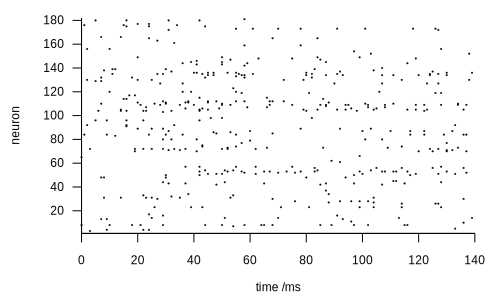

In [6]:
let () =
  let spikes_to_plot =
    Arr.get_slice [ [ 0 ] ] train_spikes
    |> fun z -> Arr.reshape z [| -1; setup.n_neural |]
  in
  let fig (module P : Plot) =
    P.plots
      (List.init 182 (fun i ->
           let st = "p pt 7 ps 0.2 lc black" in
           let fi = Float.of_int i in
           let arr = Arr.get_slice [ []; [ i ] ] spikes_to_plot in
           let arr = Arr.(fi $* arr) in
           item (A arr) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "neuron"; yrange (1., 182.) ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

## Fitting the data using iLQR-VAE : 

* Below, we will show how we use the iLQR-VAE model to fit these neural recordings.
* In general, we will initialize a model with a set of random initial parameters, then train it for a few thousand iterations, and then evaluate the performance of the trained model.
* Here, we will first look at the model at initialization. We will then skip most of the training step (a code snippet running a few iterations on a single CPU is provided as example, but the training is most efficient when parallelized over CPUs) and look at the results using a *pre-trained model*. 

In [7]:
open Model

### Initialization of the model

We initialize the model with random initial parameters. The dynamics are initially very weak. 


In [8]:
let (init_prms :Model.P.p)=
  let generative =
    let prior = U.init ~spatial_std:1.0 ~nu:20. learned in
    let dynamics = D.init learned in
    let likelihood = L.init learned in
    Generative.P.{ prior; dynamics; likelihood }
  in
  let recognition = R1.init learned in
  Model.init generative recognition

val init_prms : Model.P.p =
  {Ilqr_vae.Vae.P.generative =
    {Ilqr_vae.Generative.P.prior =
      {Ilqr_vae.Prior.Student_P.spatial_stds =
        Learned_bounded (Owl_parameters__.AD.Arr <abstr>,
         Base.Option.Some 0.001, Base.Option.None);
       nu =
        Learned_bounded (Owl_parameters__.AD.F 20., Base.Option.Some 2.,
         Base.Option.None);
       first_step =
        Learned_bounded (Owl_parameters__.AD.Arr <abstr>,
         Base.Option.Some 0.001, Base.Option.None)};
     dynamics =
      {Ilqr_vae.Dynamics.Mini_GRU_IO_P.uf =
        Learned (Owl_parameters__.AD.Arr <abstr>);
       wh = Learned (Owl_parameters__.AD.Arr <abstr>);
       uh = Learned (Owl_parameters__.AD.Arr <abstr>);
       bh = Learned (Owl_parameters__.AD.Arr <abstr>);
       b = Base.Option.Some (Learned (Owl_parameters__.AD.Arr <abstr>))};
     likelihood =
      {Ilqr_vae.Likelihood.Poisson_P.c =
        Learned (Owl_parameters__.AD.Arr <abstr>);
       c_mask = Base.Option.None;
       bias

### Illustration of the inference with the initial parameters

Below, we will use the random initial parameters to illustrate how we proceed to perform inference (and look at how an untrained model does at fitting the data). 

The helper function below is used to run the inference for a given set of parameters and trial. It finds the optimal inputs allowing the fit the data given the parameters. Latent trajectories and firing rates are then deterministic given a set of inputs. The function returns the inferred firing rates and inputs.

In [9]:
let get_us_and_rates gen_prms prms trial =
  (* get the posterior mean using iLQR; [all_us] will contain the whole
     sequence of control input as it's being optimised through consecutive
     LQR iterations; cf. movie below *)
  let u_mean, all_us =
    R.posterior_mean ~gen_prms:prms.generative prms.recognition trial
  in
  (* propagate these inputs through the generative dynamics to obtain firing rates *)
  let rates =
    G.sample ~prms:gen_prms.generative ~pre:true (`some AD.(expand_to_3d u_mean))
    |> Data.o
    |> AD.unpack_arr
  in
  rates, all_us

let () = Jupyter_notebook.clear_output ()

### Examine the initial input

iLQR-VAE fits the data by inferring the input that best explains the observations given a set of generative parameters. iLQR solves this problem *iteratively*, by converging in a few iterations to the locally optimal input. Below, we show the evolution of the input over the course of the convergence of iLQR (note that these iterations are different from training iterations, they occur during the inference procedure). 

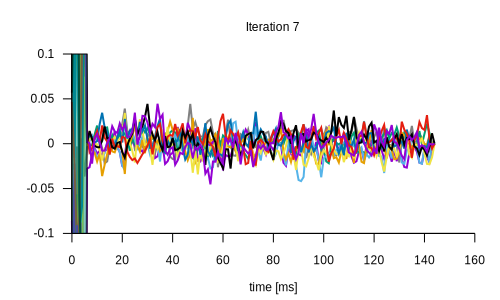

val rates : Ilqr_vae.AD.A.arr = <abstr>


In [10]:
let rates =
  (* perform inference using these initial (bad!) parameters *)
  let rates, all_us = get_us_and_rates init_prms init_prms trial in
  let open Gp in
  let display_id = Jupyter_notebook.display "text/html" "" in
  List.iteri all_us ~f:(fun i us ->
      Juplot.draw ~fmt:`svg ~size:(500, 300) ~display_id (Functions.plot_us us i);
      Unix.sleepf 0.6);
  rates

At the beginning of training, the model infers very unstructured inputs throughout the whole trial. This reflects the prior, which initially has the same variance for the first time bin and the rest of the trial, and which is very close to Gaussian.

### ...and corresponding firing rates

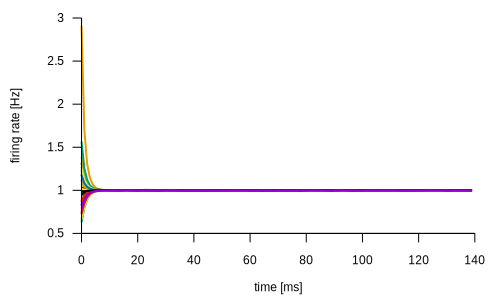

- : unit = ()


In [11]:
let fig (module P : Plot) =
  P.plots
    (List.init 50 (fun i ->
         let st = Printf.sprintf "l lw 2 lc %i" i in
         item (A (Arr.get_slice [  [ n_beg - 1; -1 ]; [ 2 * i ] ] rates)) ~style:st))
    (default_props @ [ xlabel "time [ms]"; ylabel "firing rate [Hz]" ])
in
Juplot.draw ~fmt:`svg ~size:(500, 300) fig

Given the very weak initial dynamics and random readout, and despite the fact that it's driven by inputs, the model completely fails to fit the data. The latents all decay very quickly to 0 (leading to firing rates decaying to 1). 


## Training procedure 

* We need to learn the **generative** parameters of the model and the **posterior covariance**
* This is done by optimizing the ELBO.
* To train the model, we use Adam with a sqrt decaying learning rate. 
* The learning rate, as well as the size of the latent state and the dimension of the inputs are *hyperparameters which need to be tuned*.
* We parallelize the training over CPUs; it typically takes ~6-8h on 168 CPUs with a batch size of 168. Note that it can be run on a lot fewer CPUs (ideally setting the mini_batch size to be equal or a multiple of the number of CPUs). Using smaller batches comes at the cost of noisier gradient estimates.
* Below, we will illustrate how to a run few training iterations of iLQR.

In [ ]:
let train_data, test_data =
  let data =
    lazy
      [| Data.pack
           (AD.pack_arr
              (Arr.reshape
                 (Arr.load_npy "nlb/train_spikes_0.npy")
                 [| -1; setup.n_neural |]))
       ; Data.pack (AD.pack_arr (Arr.load_npy "nlb/eval_spikes_in_0.npy"))
      |]
  in
  Data.split_and_distribute ~reuse:false ~prefix:"data" ~train:1 data

let final_prms =
  Model.train
    ~n_posterior_samples:(fun _iter -> 1)
    ~max_iter:5
    ~learning_rate:(`of_iter (fun iter -> Float.(0.004 / (1. + sqrt (of_int iter / 1.)))))
    ~init_prms
    train_data

val train_data : ([ `o ], Ilqr_vae.AD.t) Ilqr_vae.Data.t Base.Array.t =
  [|<abstr>|]
val test_data : ([ `o ], Ilqr_vae.AD.t) Ilqr_vae.Data.t Base.Array.t =
  [|<abstr>|]


## After training 

Now we will assume we had time to run 3500 iterations, and repeat the inference procedure with the parameters of the model *after training*. We will load parameters of the model after 3500 iterations, and evaluate the inferred firing rates and inputs. 

In [ ]:
let prms : Model.P.p = Misc.load_bin "final_params.bin"
let rates, all_us = get_us_and_rates prms prms trial
let () = Jupyter_notebook.clear_output ()

### Plotting the input

In [ ]:
let _ =
  let display_id = Jupyter_notebook.display "text/html" "" in
  List.iteri all_us ~f:(fun i us ->
      Juplot.draw ~fmt:`svg ~size:(500, 300) ~display_id (plot_us us i);
      Unix.sleepf 0.3)

The trained model relies *only on the initial condition* to fit the observations. This is consistent with previous findings that the dynamics of the Maze dataset are well-described by an autonomous dynamical system (Pandarinath et al, 2018). 
Interestingly, this happens here despite iLQR-VAE assuming input-driven dynamics by default, suggesting that with this choice of generative model, the "best model" is one evolving autonomously from the initial condition.

### Inferring the firing rates 

In [ ]:
let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 50 (fun i ->
           let st = Printf.sprintf "l lw 2 lc %i" i in
           item (A (Arr.get_slice [ [ n_beg - 1; -1 ]; [ i ] ] rates)) ~style:st))
      (default_props @ [ xlabel "time [ms]"; ylabel "firing rate [Hz]" ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

After training, the firing rates look a lot more reasonable - to evaluate quantitatively how well the model captures the observations, we will assess performance on co-smoothing below.



### Flexible co-smoothing

* A key advantage of iLQR-VAE is the flexibility of its inference model

* Given a set of generative parameters, inference can be performed on heterogeneous data

* This allows to evaluate co-smoothing (predictions of held-out spikes from held-in data) straightforwardly. We train the model on all the neurons, but at test time we evaluate the same model on a subset of held-in neurons by using **a subset of the readout matrix** to infer the latents from the partial observations. We then predict firing rates for all neurons using the **full readout**


<img src="figures/co_smoothing_training.png" width="100%"/>

<img src="figures/co_smoothing_testing.png" width="100%"/>


In [ ]:
(* here, we load a new trial for evaluation of the model: 
   the model will only be shown the held-in spikes, but it 
   will make predictions for the firing rates of the whole population*)

let eval_spikes_in = Arr.load_npy "nlb/eval_spikes_in_0.npy"
let eval_spikes_out = Arr.load_npy "nlb/eval_spikes_out_0.npy"
let n_neurons_eval = (Arr.shape eval_spikes_in).(2)

let test_trial =
  let open Likelihood.Poisson_P in
  let x =
    Arr.get_slice [ [ 0 ] ] eval_spikes_in
    |> fun z -> Arr.reshape z [| -1; n_train_neurons |]
  in
  let o = AD.pack_arr x in
  Data.pack o

(* truncate the model's likelihood to only consider held-in neurons *)

let truncated_prms =
  let open Vae_typ.P in
  let open Prior_typ in
  let open Generative.P in
  let open Likelihood.Poisson_P in
  let truncated_likelihood ~prms =
    let truncate (x : AD.t Owl_parameters.tag) slice =
      Owl_parameters.map (fun x -> AD.Maths.get_slice slice x) x
    in
    let held_in = [ 0; n_train_neurons - 1 ] in
    Likelihood.Poisson_P.
      { c = truncate prms.c [ held_in ]
      ; bias = truncate prms.bias [ []; held_in ]
      ; c_mask = None
      ; gain = truncate prms.gain [ []; held_in ]
      }
  in
  { generative =
      { prior = prms.generative.prior
      ; dynamics = prms.generative.dynamics
      ; likelihood = truncated_likelihood ~prms:prms.generative.likelihood
      }
  ; recognition = prms.recognition
  }

let rates, all_us = get_us_and_rates prms truncated_prms test_trial
let () = Jupyter_notebook.clear_output ()

In [ ]:
let () =
  let fig (module P : Plot) =
    P.plots
      (List.init n_test_neurons (fun i ->
           let st = Printf.sprintf "l lw 2 lc %i" i in
           item
             (A (Arr.get_slice [ [ n_beg - 1; -1 ]; [ n_train_neurons + i ] ] rates))
             ~style:st))
      (default_props
      @ [ xrange (0., 150.)
        ; xlabel "time [ms]"
        ; ylabel "firing rate [Hz]"
        ; title "Firing rate of the held out neurons"
        ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

let () =
  let spikes_to_plot =
    Arr.get_slice [ [ 0 ] ] eval_spikes_out
    |> fun z -> Arr.reshape z [| -1; n_test_neurons |]
  in
  let fig (module P : Plot) =
    P.plots
      (List.init n_test_neurons (fun i ->
           let st = Printf.sprintf "p pt 7 ps 0.4 lc %i" i in
           let arr = Arr.get_slice [ []; [ i ] ] spikes_to_plot in
           let arr = Arr.(Float.(of_int i) $* arr) in
           item (A arr) ~style:st))
      (default_props
      @ [ xrange (0., 150.)
        ; xlabel "time [ms]"
        ; ylabel "held out neurons"
        ; yrange (1., Float.(1. + of_int n_test_neurons))
        ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

To evaluate co-smoothing quantitatively, we can then compute how much better the model predicts observed spikes than a baseline that models each firing rate as the average rate for that neuron. 
Over the whole validation set (1/574 trials here), iLQR-VAE yields a co-smoothing of 0.354, suggesting that it captures the dynamics very well after learning.

### Flexible inference on heterogeneous time series

* The flexible inference model can also be used to fit *longer* or *shorter trials* than the data it was trained on

* This is different from biRNNs which need to take in data sequences from the same length as the ones they were trained on

* Below, we illustrate this by fitting the model using the whole time series, the first 100ms of the trial, and the first 50ms only

In [ ]:
let train_test_pair slice =
  let train_spikes_short = Arr.get_slice [ [ 0 ]; slice ] train_spikes in
  let test_trial_short =
    let open Likelihood.Poisson_P in
    let reshape x = Arr.reshape x [| -1; setup.n_neural |] |> AD.pack_arr in
    train_spikes_short |> reshape |> Data.pack
  in
  train_spikes_short, test_trial_short

let slice1 = [ 0; -1 ]
let slice2 = [ 0; 99 ]
let slice3 = [ 0; 49 ]

let rates (train_spikes_short, test_trial_short) =
  let module R =
    Recognition.ILQR (U) (D) (L)
      (struct
        let conv_threshold = 1E-6
        let reuse_u = `never
        let diag_time_cov = false
        let n_steps = (Arr.shape train_spikes_short).(1)
      end)
  in
  let u_mean, _ =
    R.posterior_mean ~gen_prms:prms.generative prms.recognition test_trial_short
  in
  (* propagate these inputs through the generative dynamics to obtain firing rates *)
  G.sample ~prms:prms.generative ~pre:true (`some AD.(expand_to_3d u_mean))
  |> Data.o
  |> AD.unpack_arr

let rates1 = rates (train_test_pair slice1)
let rates2 = rates (train_test_pair slice2)
let rates3 = rates (train_test_pair slice3)
let () = Jupyter_notebook.clear_output ()

In [ ]:
let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 30 (fun i ->
           if i < 10
           then (
             let st = Printf.sprintf "l lw 2 lc %i" i in
             item (A (Arr.get_slice [ [ n_beg - 1; -1 ]; [ 2 * i ] ] rates1)) ~style:st)
           else if i < 20
           then (
             let st = Printf.sprintf "l lw 2 lc %i dt 2" Int.(i - 10) in
             item
               (A (Arr.get_slice [ [ n_beg - 1; -1 ]; [ (2 * Int.(i - 10)) ] ] rates2))
               ~style:st)
           else (
             let st = Printf.sprintf "l lw 2 lc %i dt 3" Int.(i - 20) in
             item
               (A (Arr.get_slice [ [ n_beg - 1; -1 ]; [ (2 * Int.(i - 20)) ] ] rates3))
               ~style:st)))
      (default_props @ [ xlabel "time /ms"; ylabel "rates" ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

The inferred rates are similar for the different time windows used. In general, one would expect the inferred rates to be more accurate for larger time windows, as more information is available to find the firing rates.


## We've reached the end of the tutorial!  In summary : 
* iLQR-VAE is a method that models noisy observations as the output of an input-driven dynamical system.
* Unlike other methods (e.g LFADS) it uses an implicit, optimization-based recognition model, allowing for flexible inference and robust training.
* Here, we have looked more closely at how the inference procedure works, and shown that iLQR-VAE fits the neural recordings from the Maze dataset very well (here, measured using the co-smoothing metric).
* Finally, we have shown how iLQR-VAE can be used on heterogeneous data.

Thanks for following through! More details on the method can be found at in [the paper](https://www.biorxiv.org/content/10.1101/2021.10.07.463540v1.article-metrics) and I'm happy to answer any questions [by email](mailto:mmcs3@cam.ac.uk).